In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
data = pd.read_csv("color_data.csv")
data.index = data['Day']
data.drop('Day', axis=1, inplace=True)
data

,r11,r12,r13,r21,r22,r23,r31,r32,r33,r41,r42,r43,r1_avg,r2_avg,r3_avg,r4_avg,r5_avg
Day,,,,,,,,,,,,,,,,,
4,255,216,3,102,239,228,176,226,79,79,55,174,158.00,189.67,160.33,102.67,150.89
5,255,53,53,140,106,189,39,125,239,122,174,138,120.33,145.00,134.33,144.67,141.33
6,3,104,255,131,70,238,31,57,104,144,127,157,120.67,146.33,64.00,142.67,117.67
7,180,104,180,248,78,53,83,240,81,138,69,229,154.67,126.33,134.67,145.33,135.44
8,53,154,53,239,181,170,204,99,27,117,216,192,86.67,196.67,110.00,175.00,160.56
9,129,129,129,52,104,164,246,244,52,231,91,123,129.00,106.67,180.67,148.33,145.22
10,255,216,3,26,174,151,136,17,176,84,103,26,158.00,117.00,109.67,71.00,99.22
12,3,104,255,123,197,46,146,111,33,62,233,155,120.67,122.00,96.67,150.00,122.89
13,180,104,180,167,229,224,162,105,125,132,46,50,154.67,206.67,130.67,76.00,137.78


In [69]:
#Add in some additional features

data['r_all_1'] = data.apply(lambda x: np.average([x['r21'],x['r31'], x['r41']]),axis=1)
data['r_all_2'] = data.apply(lambda x: np.average([x['r22'],x['r32'], x['r42']]),axis=1)
data['r_all_3'] = data.apply(lambda x: np.average([x['r23'],x['r33'], x['r43']]),axis=1)


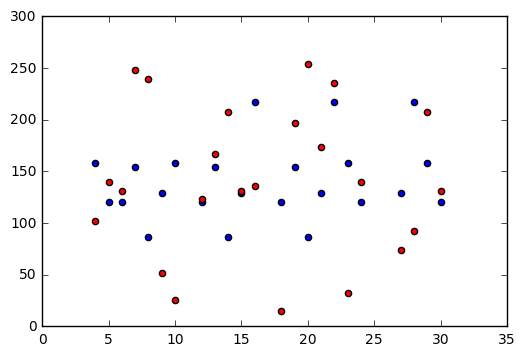

In [51]:
plt.scatter(data['Day'], data['r1_avg'], c='blue')
plt.scatter(data['Day'], data['r21'], c='red') 

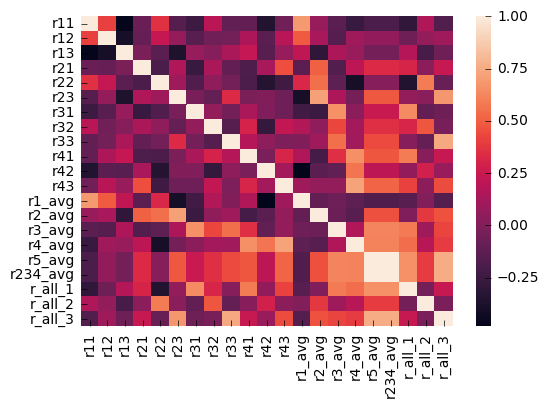

In [70]:
corr_df = data.corr(method='pearson')
sns.heatmap(corr_df)

# Training an RNN on the r1 colors
We attempt to train an RNN based the r1 color time-series with three features (RGB values). This procedure is modelled after this implementation of an RNN in keras: https://github.com/srikanthpagadala/neural-network-projects/tree/master/Time%20Series%20Prediction%20with%20LSTM%20Recurrent%20Neural%20Networks%20with%20Keras 

**Idea**: Label each color by frequency of occurence, like for language processing: 
https://medium.com/towards-data-science/lstm-by-example-using-tensorflow-feb0c1968537 

Output a one-hot vector corresponding to vector

In [26]:
# For now, use all data for training

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :(len(dataset[0]))]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :len(dataset[0])])
    return np.array(dataX), np.array(dataY)

In [38]:
look_back = 1
#Convert from dataframe to numpy array and scale to 0-1
data_r1 = data[['r11','r12','r13']].values.astype('float32') 
scale = MinMaxScaler(feature_range=(0,1))
data_r1 = scale.fit_transform(data_r1)

In [47]:
X, Y = create_dataset(data_r1, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 3))
X

array([[[ 1.00000012,  1.        ,  0.        ]],

       [[ 1.00000012,  0.        ,  0.19841272]],

       [[ 0.        ,  0.31288341,  1.00000012]],

       [[ 0.70238096,  0.31288341,  0.70238096]],

       [[ 0.19841272,  0.61963189,  0.19841272]],

       [[ 0.5       ,  0.46625766,  0.5       ]],

       [[ 1.00000012,  1.        ,  0.        ]],

       [[ 0.        ,  0.31288341,  1.00000012]],

       [[ 0.70238096,  0.31288341,  0.70238096]],

       [[ 0.19841272,  0.61963189,  0.19841272]],

       [[ 0.5       ,  0.46625766,  0.5       ]],

       [[ 1.00000012,  0.85889566,  0.7976191 ]],

       [[ 0.        ,  0.31288341,  1.00000012]],

       [[ 0.70238096,  0.31288341,  0.70238096]],

       [[ 0.19841272,  0.61963189,  0.19841272]],

       [[ 0.5       ,  0.46625766,  0.5       ]],

       [[ 1.00000012,  0.85889566,  0.7976191 ]],

       [[ 1.00000012,  1.        ,  0.        ]],

       [[ 0.        ,  0.31288341,  1.00000012]],

       [[ 0.5       ,  0.466257

In [49]:
model = Sequential()
model.add(LSTM(3,input_shape=(None,1)))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=1, verbose=0)

ValueError: Error when checking input: expected lstm_8_input to have shape (None, None, 1) but got array with shape (21, 1, 3)